In [1]:
import matplotlib.pyplot as plt
import numpy as np

from benchmark import generate_data, benchmark_single_insert, benchmark_single_query
from bloom_filter import BloomFilter
from bloom_filter2 import BloomFilter as BloomFilter2
from kathir_bloom_filter import BloomFilter as KathirBloomFilter
from pybloom_live import BloomFilter as PybloomFilter
from fastbloom_rs import BloomFilter as FastbloomFilter


In [2]:
# Configuration
N = 1_000_000
CAPACITY = 1_000_000
ERROR_RATE = 0.001

LIBRARIES = ['bloom-filter', 'bloom-filter2', 'pybloom-live', 'fastbloom-rs', 'kathir-bloom-filter']
COLORS = ['#e74c3c', '#e67e22', '#f1c40f', '#3498db', '#2ecc71']


In [3]:
# Define insert/query functions for each library
def get_insert_fn(lib, dtype):
    if lib == 'fastbloom-rs':
        return (lambda bf, item: bf.add_int(item)) if dtype == 'int' else (lambda bf, item: bf.add(item))
    elif lib == 'kathir-bloom-filter':
        return lambda bf, item: bf.insert(item)
    else:
        return lambda bf, item: bf.add(item)

def get_query_fn(lib, dtype):
    if lib == 'fastbloom-rs':
        return (lambda bf, item: bf.contains_int(item)) if dtype == 'int' else (lambda bf, item: bf.contains(item))
    else:
        return lambda bf, item: item in bf

# Run benchmarks for int and string
results = {}

for dtype in ["int", "string", "tuple", "mixed"]:
    print(f"Running {dtype} benchmarks...")
    member_data, non_member_data = generate_data(dtype, N)
    
    insert_rates = []
    query_rates = []
    
    for lib in LIBRARIES:
        # Create fresh filter for each library
        if lib == 'bloom-filter':
            bf = BloomFilter(max_elements=CAPACITY, error_rate=ERROR_RATE)
        elif lib == 'bloom-filter2':
            bf = BloomFilter2(max_elements=CAPACITY, error_rate=ERROR_RATE)
        elif lib == 'pybloom-live':
            bf = PybloomFilter(capacity=CAPACITY, error_rate=ERROR_RATE)
        elif lib == 'fastbloom-rs':
            bf = FastbloomFilter(CAPACITY, ERROR_RATE)
        elif lib == 'kathir-bloom-filter':
            bf = KathirBloomFilter(capacity=CAPACITY, false_positive_rate=ERROR_RATE)
        
        # Insertion benchmark
        insert_fn = get_insert_fn(lib, dtype)
        t = benchmark_single_insert(bf, member_data, insert_fn)
        insert_rates.append(N / t if t else None)
        
        # Query benchmark (only if insert succeeded)
        if t:
            query_fn = get_query_fn(lib, dtype)
            qt, _ = benchmark_single_query(bf, member_data, query_fn)
            query_rates.append(N / qt if qt else None)
        else:
            query_rates.append(None)
    
    results[f"{dtype}-insertion"] = insert_rates
    results[f"{dtype}-query"] = query_rates

print("Done!")

Running int benchmarks...
Running string benchmarks...
Running tuple benchmarks...
  Insert failed: ord() expected string of length 1, but int found
  Insert failed: ord() expected string of length 1, but int found
Running mixed benchmarks...
  Insert failed: unsupported operand type(s) for +: 'int' and 'str'
  Insert failed: unsupported operand type(s) for +: 'int' and 'str'
Done!


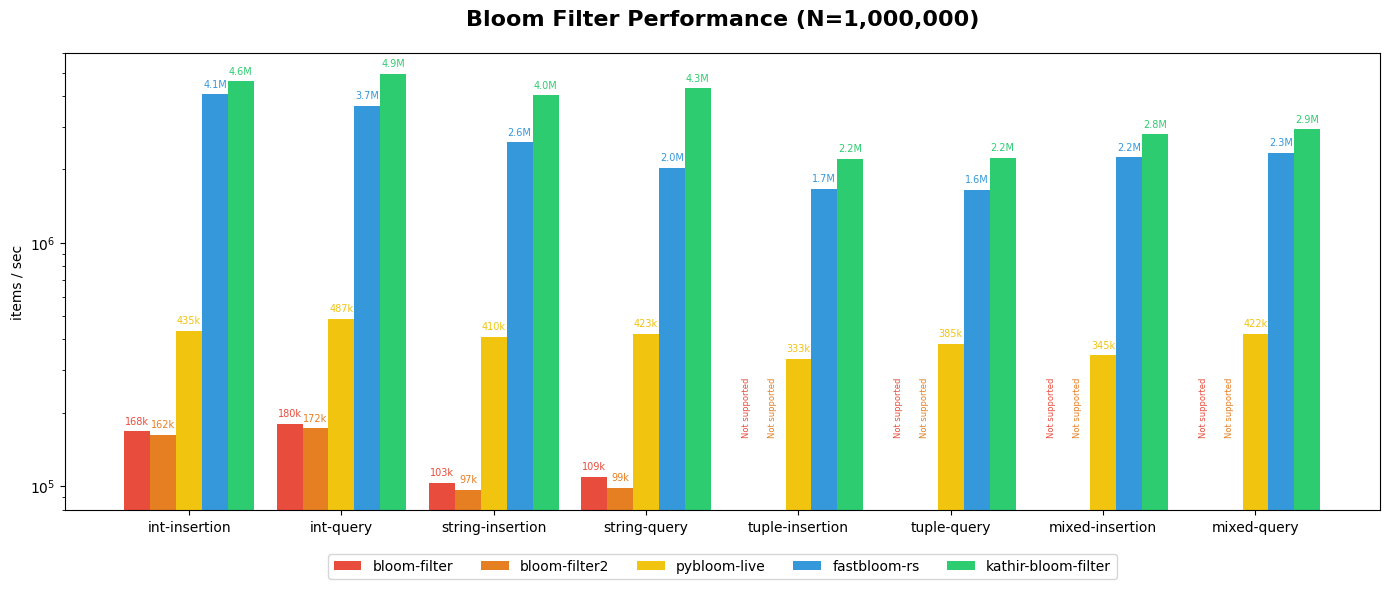

In [4]:
def fmt_rate(r):
    """Format rate: k if < 1M, M if >= 1M, or 'N/A' if None"""
    if r is None:
        return "N/A"
    if r >= 1e6:
        return f"{r/1e6:.1f}M"
    else:
        return f"{r/1e3:.0f}k"

# Group labels and data
groups = ["int-insertion", "int-query", "string-insertion", "string-query", "tuple-insertion", "tuple-query", "mixed-insertion", "mixed-query"]
x = np.arange(len(groups))
width = 0.17
n_libs = len(LIBRARIES)

fig, ax = plt.subplots(figsize=(14, 6))

# First pass: plot all bars and collect bar info for labels
bar_data = []
for i, (lib, color) in enumerate(zip(LIBRARIES, COLORS)):
    rates = [results[g][i] for g in groups]
    plot_rates = [r if r is not None else 0 for r in rates]
    bars = ax.bar(x + i * width, plot_rates, width, label=lib, color=color, linewidth=1.5)
    bar_data.append((bars, rates, color))

# Set up axes first
ax.set_ylabel('items / sec')
ax.set_title(f'Bloom Filter Performance (N={N:,})', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x + width * (n_libs - 1) / 2)
ax.set_xticklabels(groups)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=6)
ax.set_yscale('log')

# Get y-axis limits after log scale is set
y_min, y_max = ax.get_ylim()
unsupported_y = y_min * 2  # Position slightly above the bottom

# Second pass: add labels
for bars, rates, color in bar_data:
    for bar, rate in zip(bars, rates):
        if rate is None:
            ax.text(bar.get_x() + bar.get_width() / 2, unsupported_y, 'Not supported', 
                    ha='center', va='bottom', fontsize=6, rotation=90, color=color)
        else:
            label = fmt_rate(rate)
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 1.05, label,
                    ha='center', va='bottom', fontsize=7, rotation=0, color=color)

plt.tight_layout()
plt.savefig('bloom_filter_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()
